In [1]:
from sage.interfaces.gap import  get_gap_memory_pool_size, set_gap_memory_pool_size
set_gap_memory_pool_size(24364842180)

'''Graded characters in the regular block O_0.
Note: Notation is dominant: L(e) is finite dimensional, Delta(e) is projective, Delta(w0) = L(w0), ...'''


W = WeylGroup("E8", prefix="s")
[s1,s2,s3,s4,s5,s6,s7,s8] = W.simple_reflections()

##################################################################################

n = rank(W)
w0 = W.long_element()
e = W(1)


####### Kazhdan-Lusztig polynomials ##########################

# A faster implementation of KL-polynomials (using the optional package Coxeter 3) is given by this
# Fokko Ducloux’s Coxeter3 C++ library.

# Had to install it: I just typed "sage -i coxeter3" in the terminal.

# It seems that one can direcly coerce from WeylGroup to CoxeterGroup and vice versa.
# I will therefore use CoxeterGroup to calculate KL-polynomials, but for all other Bruhat business I will use WeylGroup.

R.<q> = LaurentPolynomialRing(QQ)

KL = KazhdanLusztigPolynomial(W,q)  # KL-polynomials implemented in standard Sage way
# http://doc.sagemath.org/html/en/reference/combinat/sage/combinat/kazhdan_lusztig.html


CoxeterPackage = CoxeterGroup(W, implementation="coxeter3")

def KLP(x,y):
    '''Returns the KL-polynomial, implemented in "Coxeter3" package by Fokko du Cloux.
    http://math.univ-lyon1.fr/~ducloux/coxeter/coxeter3/english/coxeter3_e.html'''
    
    if x not in W:
        x = convert_from_123(x)
    if y not in W:
        y = convert_from_123(y)
    
    return CoxeterPackage.kazhdan_lusztig_polynomial(CoxeterPackage(x), CoxeterPackage(y))
    # If "coxeter3" is not installed, remove the line 'CoxeterPackage = CoxeterGroup(W, implementation="coxeter3")'
    # and in this function return KL.P(x,y)
    #return KL.P(x,y)

#Point:
#    - standard Sage way: KL.P(x,y)
#    - faster way: KLP(x,y) 


R.<v> = LaurentPolynomialRing(QQ)
def KLPv(x,y):
    '''v-normalization: degree in the polynomial agrees with the graded degree in the Verma module.'''
    return KLP(x, y)(q=1/v^2) * v^(y.length()-x.length())


def mu(w,x):
    '''Returns the KL mu-function with arguments w,x.
    By Humphrey's BGG book p. 175 and p. 169, for w<x we have:
    mu(x,w) = mu(w0*w,w0*x),
    mu(w,x) = dim Exit^1 (L_w,L_x) = dim Exit^1(L_x,L_w) = dim Exit^1(Delta_x,L_w).'''

    if w not in W:
        w = convert_from_123(w)
    if x not in W:
        x = convert_from_123(x)
        
    if w.bruhat_le(x):
        poly_dict = KLP(w,x).dict()       
        j = (x.length()-w.length()-1)/2 
        if j not in poly_dict.keys():
            return 0
        return poly_dict[j]

    return 0


def dimExt(i,y,w):  
    '''Returns dimExt^i(Delta(y),L(w)).'''
    
    y = y*w0                               
    w = w*w0   
    poly_dict = KLP(y,w).dict()       
    j = (w.length()-y.length()-i)/2 
    if j not in poly_dict.keys():
        return 0
    return poly_dict[j]


def mult_Delta_L(y,w):
    '''Returns the Jordan-Holder multiplicity [Delta(y),L(w)] in O_0.
    This is quicker than the analogous operation on GradedChar classes because
    it does not calculate the full Delta.'''
      
    return KLP(y,w)(1)               


def mult_graded_Delta_L(w,k,x):
    '''Returns the graded Jordan-Holder multiplicity [Delta(w) shifted by k,L(x)].
    This is quicker than the analogous operation on GradedChar classes because
    it does not calculate the full Delta.''' 

    l_wx = x.length() - w.length()
    
    i = (l_wx-k)
    if i<0 or i%2!=0:
        return 0
    i = i/2
    
    KL_wx = KLP(w, x).dict()
    if i not in KL_wx.keys():
        return 0
    
    return KL_wx[i]


def earliest_occurence(x):
    '''Returns the smallest non-negative k such that L(x) occurs in Delta(e) at level k.
    To be used later in Lusztig's a function.'''
      
    for k in range(x.length()+1):
        
        if mult_graded_Delta_L(e,k,x) > 0:
            return k
    

##### Parabolic subgroups


def W_(Sigma):
    '''Parabolic subgroup W_Sigma as a list.'''
    
    return W.bruhat_interval(e,w0_(Sigma))


def minimal_rep(x,Sigma):
    '''The minimal representative of the class x*W_Sigma.'''
    
    return x.coset_representative(Sigma, side='right')


def w0_(Sigma):
    '''Returns the longest element of the parabolic subgroup defined by Sigma.
    Format of sigma: e.g. Sigma = [1,2,4] returns s4*s1*s2*s1.'''
    
    return (w0.coset_representative(Sigma, side='right')).inverse() * w0


def Maximal_elements_of_parabolics():
    '''Returns a list of the longest elements of all parabolic subgroups.'''
    
    return [w0_(Sigma) for Sigma in Subsets(range(1,rank(W)+1))]


        


    

def convert_to_123(w):
    '''Converts an element from W to the "123" string notation.
    Does not work with coefficients, as "convert_to_123_long".'''
    
    if w == W(1):
        return "e"
    
    return str(w).replace("s","").replace("*","")


def convert_from_123(string):
    '''Converts one element from W in the "123" string notation to the usual "s1*s2*s3" notation.'''
    
    if type(string)== Integer:
        string = str(string)
        
    if string == "e":
        return W(1)
    
    string = "*".join([char for char in string])
    
    for i in range(1,n+1):
        string = string.replace(str(i),"s%s"%i)
    
    return eval(string)


def DR(w):
    '''Returns the set of simple right descents of w.'''
    
    return {W.simple_reflections()[i] for i in w.descents()}


def DL(w):
    '''Returns the set of simple left   descents of w.'''
        
    return DR(w.inverse())


def AL(w):
    '''Returns the set of simple left ascends of w.'''
    
    DescLe = list(DL(w))
    AscLe = [s for s in W.simple_reflections() if s not in DescLe]
    return set(AscLe)


def AR(w):
    '''Returns the set of simple right ascends of w.'''
    
    DescRi = list(DR(w))
    AscRi = [s for s in W.simple_reflections() if s not in DescRi]
    return set(AscRi)




##############################################################
##############################################################
##############################################################




############### JOINS ###############              
                


def W_subposet(L):
    '''This is equivalent to W.bruhat_poset().subposet(),
    but without calculating the full W.bruhat_poset().'''
    
    def br_le(x,y):
        return x.bruhat_le(y)    
    return Poset((L,br_le))




def join_old(S):
    SS = [convert_from_123(a) for a in S if a not in W] + [a for a in S if a in W]
    
    U = set(W.bruhat_interval(SS[0],w0))
    for a in SS[1:]:
        U = U.intersection(set(W.bruhat_interval(a,w0)))
        
    minU = (W_subposet(list(U))).minimal_elements()
    
    if len(minU)==1:
        j = minU[0]
        return eval(convert_to_123(str(j)))
    else:
        return [eval(convert_to_123(x)) for x in minU]

    
    
    
def JM_(w):
    if w not in W:
        w = convert_from_123(w)
    result = W_subposet([x for x in join_irreducibles if x.bruhat_le(w) ]).maximal_elements()
    return [convert_from_123(convert_to_123(x)) for x in result]

def BM(w):
    if w not in W:
        w = convert_from_123(w)
    return W_subposet([x for x in bigrassmannians if x.bruhat_le(w) ]).maximal_elements()

def JM__(w):
    if w not in W:
        w = convert_from_123(w)
    DLw = DL(w)
    DRw = DR(w)
    result = []
    for x in JM_(w):
        x = convert_from_123(convert_to_123(x))
        if list(DL(x))[0] in DLw and list(DR(x))[0] in DRw:
            result.append(x)
    return result

def JM(w):
    if w not in W:
        w = convert_from_123(w)
    DLw = DL(w)
    DRw = DR(w)
    result = W_subposet([x for x in join_irreducibles if x.bruhat_le(w) and (list(DL(x))[0] in DLw) and (list(DR(x))[0] in DRw) ]).maximal_elements()
    return [convert_from_123(convert_to_123(x)) for x in result]    
    




print(DynkinDiagram(W))
    

    
    
############### JI POSETS ###############

    
def load_poset(which,i,j):
    '''which = "JI" or "BG" or "JI_socle_killing".'''
    data_folder = "Posets_data/" + CartanType(W)[0]+str(CartanType(W)[1]) + "/"
    P = load(data_folder + "%s_poset_%d%d"%(which,i,j))
    return P


def join_B(S,i,j):
    '''Here S is assumed to be a list of elements from JI[(i,j)].'''
    U = set(x for x in BG[(i,j)] if (S[0]).bruhat_le(x) )
    for a in S[1:]:
        U = U.intersection(set(x for x in BG[(i,j)] if a.bruhat_le(x) ))
        
    result = (W_subposet(list(U))).minimal_elements()
    if len(result)==1:
        return result[0]
    else:
#        raise ValueError
        return 0 # Join does not exist
    

def join(S):
    S = [convert_from_123(a) for a in S if a not in W] + [a for a in S if a in W]   

    ld = set()
    rd = set()
    for s in S:
        ld = ld.union(DL(s))
        rd = rd.union(DR(s))

    U = []
    for y in [x for x in W if DL(x).issubset(ld) and  DR(x).issubset(rd)]:
        is_upper = True
        for s in S:
            if not s.bruhat_le(y):
                is_upper = False
        if is_upper == True:
            U.append(y)
    
    return (W_subposet(U)).minimal_elements() 


def human(w):
    return convert_to_123(w)+"(%s)"%w.length()


def print_poset(P, **kwargs):
    size = kwargs.get('size', 10)
    red = kwargs.get('red', False)
    i = kwargs.get('i', None)
    j = kwargs.get('j', None)
    
    if red==True:
        color = {"red" : [(human(x[0]),human(x[1])) for x in P.cover_relations() if not is_socle_killing_pair(x[0],x[1],i,j)]}
    else:
        color = {}
    show(P.relabel(lambda x: human(x)).plot(figsize = size, vertex_shape="x", vertex_color="white",  cover_colors = color))
    
    
def r(i,j):
    return len((p[i,j]).exponents())-1

def is_socle_killing_pair(u,v,i,j):
    '''Assuming u<v, and both in the same JI(i,j).'''

    if u.bruhat_le( W.simple_reflections()[i] * v ) or u.bruhat_le(v* W.simple_reflections()[j]):
        return True
    return False

def br_le(w):
    return w.length()

        O 2
        |
        |
O---O---O---O---O---O---O
1   3   4   5   6   7   8   
E8


In [2]:
######################## E6 ########################

if (CartanType(W)[0],CartanType(W)[1])==("E",6):
    
    #bigrassmannians: 232
    bigrassmannians = [s6, s6*s5, s6*s5*s4, s6*s5*s4*s2, s6*s5*s4*s3, s6*s5*s4*s3*s1, s6*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5, s5*s6, s5*s4, s5*s6*s4*s5, s5*s4*s2, s5*s6*s4*s5*s2*s4, s5*s6*s4*s5*s2*s4*s3, s5*s6*s4*s5*s2*s4*s3*s1, s5*s4*s3, s5*s6*s4*s5*s3*s4, s5*s6*s4*s5*s3*s4*s2, s5*s6*s4*s5*s3*s2*s4, s5*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4, s5*s6*s4*s3*s2*s4*s5, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4, s4*s5, s4*s5*s6, s4*s2, s4*s5*s2*s4, s4*s5*s6*s2*s4*s5, s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3, s4*s5*s3*s4, s4*s5*s6*s3*s4*s5, s4*s5*s3*s4*s2, s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s2*s4, s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s1, s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3, s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4, s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2, s2*s4, s2*s4*s5, s2*s4*s5*s6, s2*s4*s3, s2*s4*s5*s3*s4, s2*s4*s5*s6*s3*s4*s5, s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s3*s4*s5*s2*s4, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s2*s4*s3*s1, s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3, s3*s4, s3*s4*s5, s3*s4*s5*s6, s3*s4*s2, s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s1, s3*s4*s5*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3, s3*s4*s5*s1*s3*s4, s3*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1, s1*s3, s1*s3*s4, s1*s3*s4*s5, s1*s3*s4*s5*s6, s1*s3*s4*s2, s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5, s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    BG={}
    BG[(1,1)] = [s1, s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(1,2)] = [s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2]
    BG[(1,3)] = [s1*s3, s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3]
    BG[(1,4)] = [s1*s3*s4, s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    BG[(1,5)] = [s1*s3*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    BG[(1,6)] = [s1*s3*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    BG[(2,1)] = [s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s2*s4*s3*s1]
    BG[(2,2)] = [s2, s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    BG[(2,3)] = [s2*s4*s3, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    BG[(2,4)] = [s2*s4, s2*s4*s5*s3*s4, s2*s4*s5*s6*s3*s4*s5*s2*s4, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4]
    BG[(2,5)] = [s2*s4*s5, s2*s4*s5*s6*s3*s4*s5, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5]
    BG[(2,6)] = [s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    BG[(3,1)] = [s3*s4*s5*s2*s4*s3*s1, s3*s1, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(3,2)] = [s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    BG[(3,3)] = [s3, s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s2*s4*s1*s3, s3*s4*s1*s3, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    BG[(3,4)] = [s3*s4, s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s3*s4*s5*s1*s3*s4, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    BG[(3,5)] = [s3*s4*s5, s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    BG[(3,6)] = [s3*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6]
    BG[(4,1)] = [s4*s5*s2*s4*s3*s1, s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s3*s1, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(4,2)] = [s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s3*s4*s2, s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s1*s3*s4*s2]
    BG[(4,3)] = [s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s3, s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    BG[(4,4)] = [s4, s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4, s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s3*s2*s4, s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4, s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    BG[(4,5)] = [s4*s5, s4*s5*s6*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s3*s4*s5, s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5]
    BG[(4,6)] = [s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6]
    BG[(5,1)] = [s5*s6*s4*s5*s2*s4*s3*s1, s5*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(5,2)] = [s5*s4*s2, s5*s6*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    BG[(5,3)] = [s5*s6*s4*s5*s2*s4*s3, s5*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3, s5*s6*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    BG[(5,4)] = [s5*s4, s5*s6*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4, s5*s6*s4*s5*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4]
    BG[(5,5)] = [s5, s5*s6*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5]
    BG[(5,6)] = [s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6]
    BG[(6,1)] = [s6*s5*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(6,2)] = [s6*s5*s4*s2, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    BG[(6,3)] = [s6*s5*s4*s3, s6*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3]
    BG[(6,4)] = [s6*s5*s4, s6*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4]
    BG[(6,5)] = [s6*s5, s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5]
    BG[(6,6)] = [s6, s6*s5*s4*s3*s2*s4*s5*s6]
     
    #join_irreducibles: 182
    join_irreducibles = [s1, s2, s3, s4, s5, s6, s1*s3, s2*s4, s3*s1, s3*s4, s4*s2, s4*s3, s4*s5, s5*s4, s5*s6, s6*s5, s1*s3*s4, s2*s4*s3, s2*s4*s5, s3*s4*s2, s3*s4*s5, s4*s3*s1, s4*s5*s6, s5*s4*s2, s5*s4*s3, s6*s5*s4, s1*s3*s4*s2, s1*s3*s4*s5, s2*s4*s3*s1, s2*s4*s5*s6, s3*s4*s1*s3, s3*s4*s5*s6, s4*s3*s2*s4, s4*s5*s2*s4, s4*s5*s3*s4, s5*s4*s3*s1, s5*s6*s4*s5, s6*s5*s4*s2, s6*s5*s4*s3, s1*s3*s4*s5*s6, s2*s4*s5*s3*s4, s3*s4*s5*s2*s4, s4*s5*s3*s4*s2, s4*s5*s2*s4*s3, s4*s3*s2*s4*s5, s5*s4*s3*s2*s4, s6*s5*s4*s3*s1, s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s2, s3*s4*s5*s2*s4*s3, s3*s4*s1*s3*s2*s4, s3*s4*s5*s1*s3*s4, s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3, s4*s5*s6*s2*s4*s5, s4*s5*s6*s3*s4*s5, s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4, s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4, s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s3*s4*s5, s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5, s5*s6*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s3*s4*s5*s2*s4, s5*s6*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3, s6*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    JI={}
    JI[(1,1)] = [s1, s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(1,2)] = [s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2]
    JI[(1,3)] = [s1*s3, s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3]
    JI[(1,4)] = [s1*s3*s4, s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    JI[(1,5)] = [s1*s3*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    JI[(1,6)] = [s1*s3*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    JI[(2,1)] = [s2*s4*s3*s1, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1]
    JI[(2,2)] = [s2, s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    JI[(2,3)] = [s2*s4*s3, s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    JI[(2,4)] = [s2*s4, s2*s4*s5*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s3*s4*s5*s2*s4, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4]
    JI[(2,5)] = [s2*s4*s5, s2*s4*s5*s6*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5]
    JI[(2,6)] = [s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    JI[(3,1)] = [s3*s1, s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(3,2)] = [s3*s4*s2, s3*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    JI[(3,3)] = [s3, s3*s4*s1*s3, s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    JI[(3,4)] = [s3*s4, s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4, s3*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    JI[(3,5)] = [s3*s4*s5, s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    JI[(3,6)] = [s3*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    JI[(4,1)] = [s4*s3*s1, s4*s5*s2*s4*s3*s1, s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(4,2)] = [s4*s2, s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    JI[(4,3)] = [s4*s3, s4*s5*s2*s4*s3, s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3, s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    JI[(4,4)] = [s4, s4*s3*s2*s4, s4*s5*s2*s4, s4*s5*s3*s4, s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    JI[(4,5)] = [s4*s5, s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5, s4*s5*s6*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    JI[(4,6)] = [s4*s5*s6, s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    JI[(5,1)] = [s5*s4*s3*s1, s5*s6*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(5,2)] = [s5*s4*s2, s5*s6*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    JI[(5,3)] = [s5*s4*s3, s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    JI[(5,4)] = [s5*s4, s5*s4*s3*s2*s4, s5*s6*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4, s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4]
    JI[(5,5)] = [s5, s5*s6*s4*s5, s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5]
    JI[(5,6)] = [s5*s6, s5*s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    JI[(6,1)] = [s6*s5*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(6,2)] = [s6*s5*s4*s2, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    JI[(6,3)] = [s6*s5*s4*s3, s6*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3]
    JI[(6,4)] = [s6*s5*s4, s6*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4]
    JI[(6,5)] = [s6*s5, s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5]
    JI[(6,6)] = [s6, s6*s5*s4*s3*s2*s4*s5*s6]

    penultimate = [s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s2*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s4*s1*s3*s2*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s4*s1*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3*s2*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s3*s2*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s3*s2*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4*s1*s3*s2*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s3*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s3*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4*s1*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1]
    H={}
    H[(1,1)] = s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2
    H[(1,2)] = s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1
    H[(1,3)] = s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1
    H[(1,4)] = s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(1,5)] = s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(1,6)] = s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(2,1)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s3*s2
    H[(2,2)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s1
    H[(2,3)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s3*s2*s1
    H[(2,4)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3*s2*s1
    H[(2,5)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(2,6)] = s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(3,1)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2
    H[(3,2)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1
    H[(3,3)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1
    H[(3,4)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(3,5)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(3,6)] = s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(4,1)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2
    H[(4,2)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1
    H[(4,3)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1
    H[(4,4)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(4,5)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(4,6)] = s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(5,1)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s3*s2
    H[(5,2)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4*s1*s3*s1
    H[(5,3)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s3*s2*s1
    H[(5,4)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4*s1*s3*s2*s1
    H[(5,5)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(5,6)] = s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(6,1)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2
    H[(6,2)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s4*s1*s3*s1
    H[(6,3)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s2*s1
    H[(6,4)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s4*s1*s3*s2*s1
    H[(6,5)] = s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(6,6)] = s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1

    p = {}
    p[(1,1)]=v^25 + v^31
    p[(1,2)]=v^28 + v^32
    p[(2,1)]=v^28 + v^32
    p[(1,3)]=v^26 + v^30 + v^32
    p[(3,1)]=v^26 + v^30 + v^32
    p[(1,4)]=v^27 + v^29 + v^31 + v^33
    p[(4,1)]=v^27 + v^29 + v^31 + v^33
    p[(1,5)]=v^28 + v^30 + v^34
    p[(5,1)]=v^28 + v^30 + v^34
    p[(1,6)]=v^29 + v^35
    p[(6,1)]=v^29 + v^35
    p[(2,2)]=v^25 + v^29 + v^31 + v^35
    p[(2,3)]=v^27 + v^29 + v^31 + v^33
    p[(3,2)]=v^27 + v^29 + v^31 + v^33
    p[(2,4)]=v^26 + v^28 + 2*v^30 + v^32 + v^34
    p[(4,2)]=v^26 + v^28 + 2*v^30 + v^32 + v^34
    p[(2,5)]=v^27 + v^29 + v^31 + v^33
    p[(5,2)]=v^27 + v^29 + v^31 + v^33
    p[(2,6)]=v^28 + v^32
    p[(6,2)]=v^28 + v^32
    p[(3,3)]=v^25 + v^27 + v^29 + 2*v^31 + v^33
    p[(3,4)]=v^26 + 2*v^28 + 2*v^30 + 2*v^32 + v^34
    p[(4,3)]=v^26 + 2*v^28 + 2*v^30 + 2*v^32 + v^34
    p[(3,5)]=v^27 + 2*v^29 + v^31 + v^33 + v^35
    p[(5,3)]=v^27 + 2*v^29 + v^31 + v^33 + v^35
    p[(3,6)]=v^28 + v^30 + v^34
    p[(6,3)]=v^28 + v^30 + v^34
    p[(4,4)]=v^25 + 2*v^27 + 3*v^29 + 3*v^31 + 2*v^33 + v^35
    p[(4,5)]=v^26 + 2*v^28 + 2*v^30 + 2*v^32 + v^34
    p[(5,4)]=v^26 + 2*v^28 + 2*v^30 + 2*v^32 + v^34
    p[(4,6)]=v^27 + v^29 + v^31 + v^33
    p[(6,4)]=v^27 + v^29 + v^31 + v^33
    p[(5,5)]=v^25 + v^27 + v^29 + 2*v^31 + v^33
    p[(5,6)]=v^26 + v^30 + v^32
    p[(6,5)]=v^26 + v^30 + v^32
    p[(6,6)]=v^25 + v^31


In [5]:
######################## E7 ########################
if (CartanType(W)[0],CartanType(W)[1])==("E",7):

    #bigrassmannians: 945
#    bigrassmannians = [s1, s2, s3, s4, s5, s6, s7, s1*s3, s2*s4, s3*s1, s3*s4, s4*s2, s4*s3, s4*s5, s5*s4, s5*s6, s6*s5, s6*s7, s7*s6, s1*s3*s4, s2*s4*s3, s2*s4*s5, s3*s4*s2, s3*s4*s5, s4*s3*s1, s4*s5*s6, s5*s4*s2, s5*s4*s3, s5*s6*s7, s6*s5*s4, s7*s6*s5, s1*s3*s4*s2, s1*s3*s4*s5, s2*s4*s3*s1, s2*s4*s5*s6, s3*s4*s1*s3, s3*s4*s5*s6, s4*s3*s2*s4, s4*s5*s2*s4, s4*s5*s3*s4, s4*s5*s6*s7, s5*s4*s3*s1, s5*s6*s4*s5, s6*s5*s4*s2, s6*s5*s4*s3, s6*s7*s5*s6, s7*s6*s5*s4, s1*s3*s4*s5*s6, s2*s4*s5*s3*s4, s2*s4*s5*s6*s7, s3*s4*s5*s2*s4, s3*s4*s5*s6*s7, s4*s5*s3*s4*s2, s4*s5*s2*s4*s3, s4*s5*s3*s2*s4, s4*s3*s2*s4*s5, s5*s4*s3*s2*s4, s6*s5*s4*s3*s1, s7*s6*s5*s4*s2, s7*s6*s5*s4*s3, s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7, s2*s4*s5*s3*s4*s2, s3*s4*s5*s2*s4*s3, s3*s4*s1*s3*s2*s4, s3*s4*s5*s1*s3*s4, s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3, s4*s5*s6*s2*s4*s5, s4*s5*s6*s3*s4*s5, s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4, s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6, s6*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5, s7*s6*s5*s4*s3*s1, s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s3*s4*s5, s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s1*s3*s4*s2, s3*s4*s5*s2*s4*s1*s3, s3*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5, s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s2*s4, s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4, s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6, s5*s6*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s3*s4*s5, s5*s6*s7*s4*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s2, s6*s7*s5*s6*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s5*s3*s2*s4, s6*s7*s5*s6*s4*s3*s2*s4*s5, s6*s7*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s2*s4*s3*s1, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3, s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    BG={}
    BG[(1,1)] = [s1, s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(1,2)] = [s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    BG[(1,3)] = [s1*s3, s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3]
    BG[(1,4)] = [s1*s3*s4, s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4]
    BG[(1,5)] = [s1*s3*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5]
    BG[(1,6)] = [s1*s3*s4*s5*s6, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6]
    BG[(1,7)] = [s1*s3*s4*s5*s6*s7, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    BG[(2,1)] = [s2*s4*s3*s1, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(2,2)] = [s2, s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    BG[(2,3)] = [s2*s4*s3, s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    BG[(2,4)] = [s2*s4, s2*s4*s5*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s3*s4*s5*s2*s4, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4]
    BG[(2,5)] = [s2*s4*s5, s2*s4*s5*s6*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5]
    BG[(2,6)] = [s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    BG[(2,7)] = [s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    BG[(3,1)] = [s3*s1, s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(3,2)] = [s3*s4*s2, s3*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    BG[(3,3)] = [s3, s3*s4*s1*s3, s3*s4*s5*s2*s4*s3, s3*s4*s5*s2*s4*s1*s3, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    BG[(3,4)] = [s3*s4, s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4, s3*s4*s5*s1*s3*s4, s3*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4]
    BG[(3,5)] = [s3*s4*s5, s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5]
    BG[(3,6)] = [s3*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    BG[(3,7)] = [s3*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    BG[(4,1)] = [s4*s3*s1, s4*s5*s2*s4*s3*s1, s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(4,2)] = [s4*s2, s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    BG[(4,3)] = [s4*s3, s4*s5*s2*s4*s3, s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3, s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    BG[(4,4)] = [s4, s4*s3*s2*s4, s4*s5*s2*s4, s4*s5*s3*s4, s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    BG[(4,5)] = [s4*s5, s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5, s4*s5*s6*s3*s4*s5, s4*s5*s6*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    BG[(4,6)] = [s4*s5*s6, s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6, s4*s5*s6*s7*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    BG[(4,7)] = [s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    BG[(5,1)] = [s5*s4*s3*s1, s5*s6*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(5,2)] = [s5*s4*s2, s5*s6*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    BG[(5,3)] = [s5*s4*s3, s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3, s5*s6*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    BG[(5,4)] = [s5*s4, s5*s4*s3*s2*s4, s5*s6*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4, s5*s6*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4, s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    BG[(5,5)] = [s5, s5*s6*s4*s5, s5*s4*s3*s2*s4*s5, s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s3*s4*s5, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    BG[(5,6)] = [s5*s6, s5*s6*s7*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    BG[(5,7)] = [s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    BG[(6,1)] = [s6*s5*s4*s3*s1, s6*s7*s5*s6*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(6,2)] = [s6*s5*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    BG[(6,3)] = [s6*s5*s4*s3, s6*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    BG[(6,4)] = [s6*s5*s4, s6*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4, s6*s7*s5*s6*s4*s5*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    BG[(6,5)] = [s6*s5, s6*s7*s5*s6*s4*s5, s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    BG[(6,6)] = [s6, s6*s7*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6, s6*s7*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    BG[(6,7)] = [s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    BG[(7,1)] = [s7*s6*s5*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(7,2)] = [s7*s6*s5*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2]
    BG[(7,3)] = [s7*s6*s5*s4*s3, s7*s6*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3]
    BG[(7,4)] = [s7*s6*s5*s4, s7*s6*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    BG[(7,5)] = [s7*s6*s5, s7*s6*s5*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    BG[(7,6)] = [s7*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    BG[(7,7)] = [s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
 
    #join_irreducibles: 528
    join_irreducibles = [s1, s2, s3, s4, s5, s6, s7, s1*s3, s2*s4, s3*s1, s3*s4, s4*s2, s4*s3, s4*s5, s5*s4, s5*s6, s6*s5, s6*s7, s7*s6, s1*s3*s4, s2*s4*s3, s2*s4*s5, s3*s4*s2, s3*s4*s5, s4*s3*s1, s4*s5*s6, s5*s4*s2, s5*s4*s3, s5*s6*s7, s6*s5*s4, s7*s6*s5, s1*s3*s4*s2, s1*s3*s4*s5, s2*s4*s3*s1, s2*s4*s5*s6, s3*s4*s1*s3, s3*s4*s5*s6, s4*s3*s2*s4, s4*s5*s2*s4, s4*s5*s3*s4, s4*s5*s6*s7, s5*s4*s3*s1, s5*s6*s4*s5, s6*s5*s4*s2, s6*s5*s4*s3, s6*s7*s5*s6, s7*s6*s5*s4, s1*s3*s4*s5*s6, s2*s4*s5*s3*s4, s2*s4*s5*s6*s7, s3*s4*s5*s2*s4, s3*s4*s5*s6*s7, s4*s5*s3*s4*s2, s4*s5*s2*s4*s3, s4*s3*s2*s4*s5, s5*s4*s3*s2*s4, s6*s5*s4*s3*s1, s7*s6*s5*s4*s2, s7*s6*s5*s4*s3, s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7, s2*s4*s5*s3*s4*s2, s3*s4*s5*s2*s4*s3, s3*s4*s1*s3*s2*s4, s3*s4*s5*s1*s3*s4, s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3, s4*s5*s6*s2*s4*s5, s4*s5*s6*s3*s4*s5, s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4, s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6, s6*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5, s7*s6*s5*s4*s3*s1, s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s3*s4*s5, s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4, s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6, s5*s6*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s3*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s2, s6*s7*s5*s6*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s2*s4*s3*s1, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    JI={}
    JI[(1,1)] = [s1, s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(1,2)] = [s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    JI[(1,3)] = [s1*s3, s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3]
    JI[(1,4)] = [s1*s3*s4, s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4]
    JI[(1,5)] = [s1*s3*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5]
    JI[(1,6)] = [s1*s3*s4*s5*s6, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6]
    JI[(1,7)] = [s1*s3*s4*s5*s6*s7, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    JI[(2,1)] = [s2*s4*s3*s1, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(2,2)] = [s2, s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    JI[(2,3)] = [s2*s4*s3, s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    JI[(2,4)] = [s2*s4, s2*s4*s5*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s3*s4*s5*s2*s4, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4]
    JI[(2,5)] = [s2*s4*s5, s2*s4*s5*s6*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5]
    JI[(2,6)] = [s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    JI[(2,7)] = [s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    JI[(3,1)] = [s3*s1, s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(3,2)] = [s3*s4*s2, s3*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    JI[(3,3)] = [s3, s3*s4*s1*s3, s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    JI[(3,4)] = [s3*s4, s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4, s3*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4]
    JI[(3,5)] = [s3*s4*s5, s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5]
    JI[(3,6)] = [s3*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    JI[(3,7)] = [s3*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    JI[(4,1)] = [s4*s3*s1, s4*s5*s2*s4*s3*s1, s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(4,2)] = [s4*s2, s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    JI[(4,3)] = [s4*s3, s4*s5*s2*s4*s3, s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3, s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    JI[(4,4)] = [s4, s4*s3*s2*s4, s4*s5*s2*s4, s4*s5*s3*s4, s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    JI[(4,5)] = [s4*s5, s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5, s4*s5*s6*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    JI[(4,6)] = [s4*s5*s6, s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    JI[(4,7)] = [s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    JI[(5,1)] = [s5*s4*s3*s1, s5*s6*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(5,2)] = [s5*s4*s2, s5*s6*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    JI[(5,3)] = [s5*s4*s3, s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    JI[(5,4)] = [s5*s4, s5*s4*s3*s2*s4, s5*s6*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4, s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    JI[(5,5)] = [s5, s5*s6*s4*s5, s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    JI[(5,6)] = [s5*s6, s5*s6*s7*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    JI[(5,7)] = [s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    JI[(6,1)] = [s6*s5*s4*s3*s1, s6*s7*s5*s6*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(6,2)] = [s6*s5*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    JI[(6,3)] = [s6*s5*s4*s3, s6*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    JI[(6,4)] = [s6*s5*s4, s6*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    JI[(6,5)] = [s6*s5, s6*s7*s5*s6*s4*s5, s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    JI[(6,6)] = [s6, s6*s7*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    JI[(6,7)] = [s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    JI[(7,1)] = [s7*s6*s5*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(7,2)] = [s7*s6*s5*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2]
    JI[(7,3)] = [s7*s6*s5*s4*s3, s7*s6*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3]
    JI[(7,4)] = [s7*s6*s5*s4, s7*s6*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    JI[(7,5)] = [s7*s6*s5, s7*s6*s5*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    JI[(7,6)] = [s7*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    JI[(7,7)] = [s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]

#    penultimate = [s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s4*s1*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s3*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s3*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4*s1*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1]
    H={}
    H[(1,1)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2
    H[(1,2)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s4*s1*s3*s1
    H[(1,3)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s2*s1
    H[(1,4)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s4*s1*s3*s2*s1
    H[(1,5)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(1,6)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(1,7)] = s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(2,1)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s3*s2
    H[(2,2)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s1
    H[(2,3)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s3*s2*s1
    H[(2,4)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3*s2*s1
    H[(2,5)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(2,6)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(2,7)] = s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(3,1)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s3*s2
    H[(3,2)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4*s1*s3*s1
    H[(3,3)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s3*s2*s1
    H[(3,4)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4*s1*s3*s2*s1
    H[(3,5)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(3,6)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(3,7)] = s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(4,1)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2
    H[(4,2)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1
    H[(4,3)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1
    H[(4,4)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(4,5)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(4,6)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(4,7)] = s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(5,1)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2
    H[(5,2)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1
    H[(5,3)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1
    H[(5,4)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(5,5)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(5,6)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(5,7)] = s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(6,1)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2
    H[(6,2)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1
    H[(6,3)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1
    H[(6,4)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(6,5)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(6,6)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(6,7)] = s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(7,1)] = s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2
    H[(7,2)] = s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1
    H[(7,3)] = s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1
    H[(7,4)] = s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(7,5)] = s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(7,6)] = s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(7,7)] = s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1

    p = {}
    p[(1,1)]=v^46 + v^52 + v^56 + v^62
    p[(1,2)]=v^49 + v^53 + v^55 + v^59
    p[(2,1)]=v^49 + v^53 + v^55 + v^59
    p[(1,3)]=v^47 + v^51 + v^53 + v^55 + v^57 + v^61
    p[(3,1)]=v^47 + v^51 + v^53 + v^55 + v^57 + v^61
    p[(1,4)]=v^48 + v^50 + v^52 + 2*v^54 + v^56 + v^58 + v^60
    p[(4,1)]=v^48 + v^50 + v^52 + 2*v^54 + v^56 + v^58 + v^60
    p[(1,5)]=v^49 + v^51 + v^53 + v^55 + v^57 + v^59
    p[(5,1)]=v^49 + v^51 + v^53 + v^55 + v^57 + v^59
    p[(1,6)]=v^50 + v^52 + v^56 + v^58
    p[(6,1)]=v^50 + v^52 + v^56 + v^58
    p[(1,7)]=v^51 + v^57
    p[(7,1)]=v^51 + v^57
    p[(2,2)]=v^46 + v^50 + v^52 + v^54 + v^56 + v^58 + v^62
    p[(2,3)]=v^48 + v^50 + v^52 + 2*v^54 + v^56 + v^58 + v^60
    p[(3,2)]=v^48 + v^50 + v^52 + 2*v^54 + v^56 + v^58 + v^60
    p[(2,4)]=v^47 + v^49 + 2*v^51 + 2*v^53 + 2*v^55 + 2*v^57 + v^59 + v^61
    p[(4,2)]=v^47 + v^49 + 2*v^51 + 2*v^53 + 2*v^55 + 2*v^57 + v^59 + v^61
    p[(2,5)]=v^48 + v^50 + 2*v^52 + v^54 + 2*v^56 + v^58 + v^60
    p[(5,2)]=v^48 + v^50 + 2*v^52 + v^54 + 2*v^56 + v^58 + v^60
    p[(2,6)]=v^49 + v^51 + v^53 + v^55 + v^57 + v^59
    p[(6,2)]=v^49 + v^51 + v^53 + v^55 + v^57 + v^59
    p[(2,7)]=v^50 + v^54 + v^58
    p[(7,2)]=v^50 + v^54 + v^58
    p[(3,3)]=v^46 + v^48 + v^50 + 2*v^52 + 2*v^54 + 2*v^56 + v^58 + v^60 + v^62
    p[(3,4)]=v^47 + 2*v^49 + 2*v^51 + 3*v^53 + 3*v^55 + 2*v^57 + 2*v^59 + v^61
    p[(4,3)]=v^47 + 2*v^49 + 2*v^51 + 3*v^53 + 3*v^55 + 2*v^57 + 2*v^59 + v^61
    p[(3,5)]=v^48 + 2*v^50 + 2*v^52 + 2*v^54 + 2*v^56 + 2*v^58 + v^60
    p[(5,3)]=v^48 + 2*v^50 + 2*v^52 + 2*v^54 + 2*v^56 + 2*v^58 + v^60
    p[(3,6)]=v^49 + 2*v^51 + v^53 + v^55 + 2*v^57 + v^59
    p[(6,3)]=v^49 + 2*v^51 + v^53 + v^55 + 2*v^57 + v^59
    p[(3,7)]=v^50 + v^52 + v^56 + v^58
    p[(7,3)]=v^50 + v^52 + v^56 + v^58
    p[(4,4)]=v^46 + 2*v^48 + 3*v^50 + 4*v^52 + 4*v^54 + 4*v^56 + 3*v^58 + 2*v^60 + v^62
    p[(4,5)]=v^47 + 2*v^49 + 3*v^51 + 3*v^53 + 3*v^55 + 3*v^57 + 2*v^59 + v^61
    p[(5,4)]=v^47 + 2*v^49 + 3*v^51 + 3*v^53 + 3*v^55 + 3*v^57 + 2*v^59 + v^61
    p[(4,6)]=v^48 + 2*v^50 + 2*v^52 + 2*v^54 + 2*v^56 + 2*v^58 + v^60
    p[(6,4)]=v^48 + 2*v^50 + 2*v^52 + 2*v^54 + 2*v^56 + 2*v^58 + v^60
    p[(4,7)]=v^49 + v^51 + v^53 + v^55 + v^57 + v^59
    p[(7,4)]=v^49 + v^51 + v^53 + v^55 + v^57 + v^59
    p[(5,5)]=v^46 + v^48 + 2*v^50 + 2*v^52 + 3*v^54 + 2*v^56 + 2*v^58 + v^60 + v^62
    p[(5,6)]=v^47 + v^49 + v^51 + 2*v^53 + 2*v^55 + v^57 + v^59 + v^61
    p[(6,5)]=v^47 + v^49 + v^51 + 2*v^53 + 2*v^55 + v^57 + v^59 + v^61
    p[(5,7)]=v^48 + v^52 + v^54 + v^56 + v^60
    p[(7,5)]=v^48 + v^52 + v^54 + v^56 + v^60
    p[(6,6)]=v^46 + v^48 + v^52 + 2*v^54 + v^56 + v^60 + v^62
    p[(6,7)]=v^47 + v^53 + v^55 + v^61
    p[(7,6)]=v^47 + v^53 + v^55 + v^61
    p[(7,7)]=v^46 + v^54 + v^62
    

In [2]:
######################## E8 ########################
if (CartanType(W)[0],CartanType(W)[1])==("E",8):
    
    #bigrassmannians: 8460
#    bigrassmannians = [s1, s2, s3, s4, s5, s6, s7, s8, s1*s3, s2*s4, s3*s1, s3*s4, s4*s2, s4*s3, s4*s5, s5*s4, s5*s6, s6*s5, s6*s7, s7*s6, s7*s8, s8*s7, s1*s3*s4, s2*s4*s3, s2*s4*s5, s3*s4*s2, s3*s4*s5, s4*s3*s1, s4*s5*s6, s5*s4*s2, s5*s4*s3, s5*s6*s7, s6*s5*s4, s6*s7*s8, s7*s6*s5, s8*s7*s6, s1*s3*s4*s2, s1*s3*s4*s5, s2*s4*s3*s1, s2*s4*s5*s6, s3*s4*s1*s3, s3*s4*s5*s6, s4*s3*s2*s4, s4*s5*s2*s4, s4*s5*s3*s4, s4*s5*s6*s7, s5*s4*s3*s1, s5*s6*s4*s5, s5*s6*s7*s8, s6*s5*s4*s2, s6*s5*s4*s3, s6*s7*s5*s6, s7*s6*s5*s4, s7*s8*s6*s7, s8*s7*s6*s5, s1*s3*s4*s5*s6, s2*s4*s5*s3*s4, s2*s4*s5*s6*s7, s3*s4*s5*s2*s4, s3*s4*s5*s6*s7, s4*s5*s3*s4*s2, s4*s5*s2*s4*s3, s4*s5*s3*s2*s4, s4*s3*s2*s4*s5, s4*s5*s6*s7*s8, s5*s4*s3*s2*s4, s6*s5*s4*s3*s1, s7*s6*s5*s4*s2, s7*s6*s5*s4*s3, s8*s7*s6*s5*s4, s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7, s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s7*s8, s3*s4*s5*s2*s4*s3, s3*s4*s1*s3*s2*s4, s3*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8, s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3, s4*s5*s6*s2*s4*s5, s4*s5*s6*s3*s4*s5, s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4, s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6, s6*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5, s6*s7*s8*s5*s6*s7, s7*s6*s5*s4*s3*s1, s7*s8*s6*s7*s5*s6, s8*s7*s6*s5*s4*s2, s8*s7*s6*s5*s4*s3, s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s8, s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s3*s4*s5, s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s1*s3*s4*s2, s3*s4*s5*s2*s4*s1*s3, s3*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5, s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s2*s4, s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4, s8*s7*s6*s5*s4*s3*s1, s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8, s5*s6*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s3*s4*s5, s5*s6*s7*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8, s6*s7*s5*s6*s4*s5*s3*s4*s2, s6*s7*s5*s6*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s5*s3*s2*s4, s6*s7*s5*s6*s4*s3*s2*s4*s5, s6*s7*s5*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s2*s4*s3*s1, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8, s7*s8*s6*s7*s5*s6*s4*s5*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s1*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7, s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s3*s2*s4*s5, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3, s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6, s6*s7*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s8*s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s8*s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s8*s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s4*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    BG={}
    BG[(1,1)] = [s1, s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(1,2)] = [s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    BG[(1,3)] = [s1*s3, s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3]
    BG[(1,4)] = [s1*s3*s4, s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4]
    BG[(1,5)] = [s1*s3*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5]
    BG[(1,6)] = [s1*s3*s4*s5*s6, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6]
    BG[(1,7)] = [s1*s3*s4*s5*s6*s7, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    BG[(1,8)] = [s1*s3*s4*s5*s6*s7*s8, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8]
    BG[(2,1)] = [s2*s4*s3*s1, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(2,2)] = [s2, s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    BG[(2,3)] = [s2*s4*s3, s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    BG[(2,4)] = [s2*s4, s2*s4*s5*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s3*s4*s5*s2*s4, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4]
    BG[(2,5)] = [s2*s4*s5, s2*s4*s5*s6*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5]
    BG[(2,6)] = [s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    BG[(2,7)] = [s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    BG[(2,8)] = [s2*s4*s5*s6*s7*s8, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8]
    BG[(3,1)] = [s3*s1, s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(3,2)] = [s3*s4*s2, s3*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    BG[(3,3)] = [s3, s3*s4*s1*s3, s3*s4*s5*s2*s4*s3, s3*s4*s5*s2*s4*s1*s3, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    BG[(3,4)] = [s3*s4, s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4, s3*s4*s5*s1*s3*s4, s3*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4]
    BG[(3,5)] = [s3*s4*s5, s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5]
    BG[(3,6)] = [s3*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    BG[(3,7)] = [s3*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    BG[(3,8)] = [s3*s4*s5*s6*s7*s8, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8]
    BG[(4,1)] = [s4*s3*s1, s4*s5*s2*s4*s3*s1, s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(4,2)] = [s4*s2, s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    BG[(4,3)] = [s4*s3, s4*s5*s2*s4*s3, s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3, s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    BG[(4,4)] = [s4, s4*s3*s2*s4, s4*s5*s2*s4, s4*s5*s3*s4, s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    BG[(4,5)] = [s4*s5, s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5, s4*s5*s6*s3*s4*s5, s4*s5*s6*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    BG[(4,6)] = [s4*s5*s6, s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6, s4*s5*s6*s7*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    BG[(4,7)] = [s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    BG[(4,8)] = [s4*s5*s6*s7*s8, s4*s3*s2*s4*s5*s6*s7*s8, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8]
    BG[(5,1)] = [s5*s4*s3*s1, s5*s6*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(5,2)] = [s5*s4*s2, s5*s6*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    BG[(5,3)] = [s5*s4*s3, s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3, s5*s6*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    BG[(5,4)] = [s5*s4, s5*s4*s3*s2*s4, s5*s6*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4, s5*s6*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4, s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    BG[(5,5)] = [s5, s5*s6*s4*s5, s5*s4*s3*s2*s4*s5, s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s3*s4*s5, s5*s6*s7*s4*s5*s6*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    BG[(5,6)] = [s5*s6, s5*s6*s7*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    BG[(5,7)] = [s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    BG[(5,8)] = [s5*s6*s7*s8, s5*s4*s3*s2*s4*s5*s6*s7*s8, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8]
    BG[(6,1)] = [s6*s5*s4*s3*s1, s6*s7*s5*s6*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(6,2)] = [s6*s5*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    BG[(6,3)] = [s6*s5*s4*s3, s6*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    BG[(6,4)] = [s6*s5*s4, s6*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4, s6*s7*s5*s6*s4*s5*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    BG[(6,5)] = [s6*s5, s6*s7*s5*s6*s4*s5, s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5, s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    BG[(6,6)] = [s6, s6*s7*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6, s6*s7*s5*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    BG[(6,7)] = [s6*s7, s6*s7*s8*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    BG[(6,8)] = [s6*s7*s8, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8]
    BG[(7,1)] = [s7*s6*s5*s4*s3*s1, s7*s8*s6*s7*s5*s6*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(7,2)] = [s7*s6*s5*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    BG[(7,3)] = [s7*s6*s5*s4*s3, s7*s6*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s2*s4*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s8*s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    BG[(7,4)] = [s7*s6*s5*s4, s7*s6*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s8*s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s4*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    BG[(7,5)] = [s7*s6*s5, s7*s6*s5*s4*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5, s7*s8*s6*s7*s5*s6*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    BG[(7,6)] = [s7*s6, s7*s8*s6*s7*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    BG[(7,7)] = [s7, s7*s8*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    BG[(7,8)] = [s7*s8, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8]
    BG[(8,1)] = [s8*s7*s6*s5*s4*s3*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    BG[(8,2)] = [s8*s7*s6*s5*s4*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2]
    BG[(8,3)] = [s8*s7*s6*s5*s4*s3, s8*s7*s6*s5*s4*s3*s2*s4*s1*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s1*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3]
    BG[(8,4)] = [s8*s7*s6*s5*s4, s8*s7*s6*s5*s4*s3*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    BG[(8,5)] = [s8*s7*s6*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    BG[(8,6)] = [s8*s7*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    BG[(8,7)] = [s8*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    BG[(8,8)] = [s8, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8]
    print("BG loaded!")

    #join_irreducibles: 2060
#    join_irreducibles = [s1, s2, s3, s4, s5, s6, s7, s8, s1*s3, s2*s4, s3*s1, s3*s4, s4*s2, s4*s3, s4*s5, s5*s4, s5*s6, s6*s5, s6*s7, s7*s6, s7*s8, s8*s7, s1*s3*s4, s2*s4*s3, s2*s4*s5, s3*s4*s2, s3*s4*s5, s4*s3*s1, s4*s5*s6, s5*s4*s2, s5*s4*s3, s5*s6*s7, s6*s5*s4, s6*s7*s8, s7*s6*s5, s8*s7*s6, s1*s3*s4*s2, s1*s3*s4*s5, s2*s4*s3*s1, s2*s4*s5*s6, s3*s4*s1*s3, s3*s4*s5*s6, s4*s3*s2*s4, s4*s5*s2*s4, s4*s5*s3*s4, s4*s5*s6*s7, s5*s4*s3*s1, s5*s6*s4*s5, s5*s6*s7*s8, s6*s5*s4*s2, s6*s5*s4*s3, s6*s7*s5*s6, s7*s6*s5*s4, s7*s8*s6*s7, s8*s7*s6*s5, s1*s3*s4*s5*s6, s2*s4*s5*s3*s4, s2*s4*s5*s6*s7, s3*s4*s5*s2*s4, s3*s4*s5*s6*s7, s4*s5*s3*s4*s2, s4*s5*s2*s4*s3, s4*s3*s2*s4*s5, s4*s5*s6*s7*s8, s5*s4*s3*s2*s4, s6*s5*s4*s3*s1, s7*s6*s5*s4*s2, s7*s6*s5*s4*s3, s8*s7*s6*s5*s4, s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7, s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s7*s8, s3*s4*s5*s2*s4*s3, s3*s4*s1*s3*s2*s4, s3*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8, s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3, s4*s5*s6*s2*s4*s5, s4*s5*s6*s3*s4*s5, s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4, s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6, s6*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5, s6*s7*s8*s5*s6*s7, s7*s6*s5*s4*s3*s1, s7*s8*s6*s7*s5*s6, s8*s7*s6*s5*s4*s2, s8*s7*s6*s5*s4*s3, s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s8, s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s3*s4*s5, s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4, s8*s7*s6*s5*s4*s3*s1, s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8, s5*s6*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8, s6*s7*s5*s6*s4*s5*s3*s4*s2, s6*s7*s5*s6*s4*s5*s2*s4*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s2*s4*s3*s1, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8, s7*s8*s6*s7*s5*s6*s4*s5*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s1*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s8*s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s8*s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    JI={}
    JI[(1,1)] = [s1, s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(1,2)] = [s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    JI[(1,3)] = [s1*s3, s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3]
    JI[(1,4)] = [s1*s3*s4, s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4]
    JI[(1,5)] = [s1*s3*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5]
    JI[(1,6)] = [s1*s3*s4*s5*s6, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6]
    JI[(1,7)] = [s1*s3*s4*s5*s6*s7, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    JI[(1,8)] = [s1*s3*s4*s5*s6*s7*s8, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8]
    JI[(2,1)] = [s2*s4*s3*s1, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(2,2)] = [s2, s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    JI[(2,3)] = [s2*s4*s3, s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    JI[(2,4)] = [s2*s4, s2*s4*s5*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s3*s4*s5*s2*s4, s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4]
    JI[(2,5)] = [s2*s4*s5, s2*s4*s5*s6*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5]
    JI[(2,6)] = [s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    JI[(2,7)] = [s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    JI[(2,8)] = [s2*s4*s5*s6*s7*s8, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8]
    JI[(3,1)] = [s3*s1, s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(3,2)] = [s3*s4*s2, s3*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    JI[(3,3)] = [s3, s3*s4*s1*s3, s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    JI[(3,4)] = [s3*s4, s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4, s3*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4]
    JI[(3,5)] = [s3*s4*s5, s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5]
    JI[(3,6)] = [s3*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    JI[(3,7)] = [s3*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    JI[(3,8)] = [s3*s4*s5*s6*s7*s8, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8]
    JI[(4,1)] = [s4*s3*s1, s4*s5*s2*s4*s3*s1, s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(4,2)] = [s4*s2, s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    JI[(4,3)] = [s4*s3, s4*s5*s2*s4*s3, s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3, s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    JI[(4,4)] = [s4, s4*s3*s2*s4, s4*s5*s2*s4, s4*s5*s3*s4, s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    JI[(4,5)] = [s4*s5, s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5, s4*s5*s6*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    JI[(4,6)] = [s4*s5*s6, s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    JI[(4,7)] = [s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    JI[(4,8)] = [s4*s5*s6*s7*s8, s4*s3*s2*s4*s5*s6*s7*s8, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8]
    JI[(5,1)] = [s5*s4*s3*s1, s5*s6*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(5,2)] = [s5*s4*s2, s5*s6*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    JI[(5,3)] = [s5*s4*s3, s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    JI[(5,4)] = [s5*s4, s5*s4*s3*s2*s4, s5*s6*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4, s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    JI[(5,5)] = [s5, s5*s6*s4*s5, s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    JI[(5,6)] = [s5*s6, s5*s6*s7*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    JI[(5,7)] = [s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    JI[(5,8)] = [s5*s6*s7*s8, s5*s4*s3*s2*s4*s5*s6*s7*s8, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s4*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8]
    JI[(6,1)] = [s6*s5*s4*s3*s1, s6*s7*s5*s6*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(6,2)] = [s6*s5*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    JI[(6,3)] = [s6*s5*s4*s3, s6*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    JI[(6,4)] = [s6*s5*s4, s6*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4, s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5*s1*s3*s4, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    JI[(6,5)] = [s6*s5, s6*s7*s5*s6*s4*s5, s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    JI[(6,6)] = [s6, s6*s7*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    JI[(6,7)] = [s6*s7, s6*s7*s8*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    JI[(6,8)] = [s6*s7*s8, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s7*s8*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8]
    JI[(7,1)] = [s7*s6*s5*s4*s3*s1, s7*s8*s6*s7*s5*s6*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(7,2)] = [s7*s6*s5*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4*s2]
    JI[(7,3)] = [s7*s6*s5*s4*s3, s7*s6*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s2*s4*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s8*s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3]
    JI[(7,4)] = [s7*s6*s5*s4, s7*s6*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s8*s6*s7*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    JI[(7,5)] = [s7*s6*s5, s7*s6*s5*s4*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    JI[(7,6)] = [s7*s6, s7*s8*s6*s7*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    JI[(7,7)] = [s7, s7*s8*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    JI[(7,8)] = [s7*s8, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8, s7*s8*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8]
    JI[(8,1)] = [s8*s7*s6*s5*s4*s3*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]
    JI[(8,2)] = [s8*s7*s6*s5*s4*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2]
    JI[(8,3)] = [s8*s7*s6*s5*s4*s3, s8*s7*s6*s5*s4*s3*s2*s4*s1*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3]
    JI[(8,4)] = [s8*s7*s6*s5*s4, s8*s7*s6*s5*s4*s3*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4]
    JI[(8,5)] = [s8*s7*s6*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5]
    JI[(8,6)] = [s8*s7*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6]
    JI[(8,7)] = [s8*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7]
    JI[(8,8)] = [s8, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s8, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8]
    print("JI loaded!")
    
#    penultimate = [s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s4*s1*s3*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s3*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s3*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4*s1*s3*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1, s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1]
    H={}
    H[(1,1)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2
    H[(1,2)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s4*s1*s3*s1
    H[(1,3)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s2*s1
    H[(1,4)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s4*s1*s3*s2*s1
    H[(1,5)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(1,6)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(1,7)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(1,8)] = s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(2,1)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s3*s2
    H[(2,2)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s1
    H[(2,3)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s3*s2*s1
    H[(2,4)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4*s1*s3*s2*s1
    H[(2,5)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(2,6)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(2,7)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(2,8)] = s3*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(3,1)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s3*s2
    H[(3,2)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4*s1*s3*s1
    H[(3,3)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s3*s2*s1
    H[(3,4)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s1*s3*s2*s4*s1*s3*s2*s1
    H[(3,5)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(3,6)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(3,7)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(3,8)] = s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(4,1)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2
    H[(4,2)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1
    H[(4,3)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1
    H[(4,4)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(4,5)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(4,6)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(4,7)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(4,8)] = s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(5,1)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2
    H[(5,2)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1
    H[(5,3)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1
    H[(5,4)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(5,5)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(5,6)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(5,7)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(5,8)] = s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(6,1)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2
    H[(6,2)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1
    H[(6,3)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1
    H[(6,4)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(6,5)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(6,6)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(6,7)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(6,8)] = s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(7,1)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2
    H[(7,2)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1
    H[(7,3)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1
    H[(7,4)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(7,5)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(7,6)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(7,7)] = s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(7,8)] = s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(8,1)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2
    H[(8,2)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s1
    H[(8,3)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s3*s2*s1
    H[(8,4)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(8,5)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(8,6)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(8,7)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    H[(8,8)] = s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s7*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4*s1*s3*s2*s1
    print("H loaded!")
    
    p = {}
    p[(1,1)]=v^119 + v^113 + v^109 + v^107 + v^103 + v^101 + v^97 + v^91
    p[(1,2)]=v^116 + v^112 + v^110 + v^108 + v^106 + v^104 + v^102 + v^100 + v^98 + v^94
    p[(1,3)]=v^118 + v^114 + v^112 + v^110 + 2*v^108 + v^106 + v^104 + 2*v^102 + v^100 + v^98 + v^96 + v^92
    p[(1,4)]=v^93 + v^95 + v^97 + 2*v^99 + 2*v^101 + 2*v^103 + 2*v^105 + 2*v^107 + 2*v^109 + 2*v^111 + v^113 + v^115 + v^117
    p[(1,5)]=v^94 + v^96 + v^98 + 2*v^100 + v^102 + 2*v^104 + 2*v^106 + v^108 + 2*v^110 + v^112 + v^114 + v^116
    p[(1,6)]=v^95 + v^97 + v^99 + v^101 + v^103 + 2*v^105 + v^107 + v^109 + v^111 + v^113 + v^115
    p[(1,7)]=v^96 + v^98 + v^102 + v^104 + v^106 + v^108 + v^112 + v^114
    p[(1,8)]=v^97 + v^103 + v^107 + v^113
    p[(2,1)]=v^116 + v^112 + v^110 + v^108 + v^106 + v^104 + v^102 + v^100 + v^98 + v^94
    p[(2,2)]=v^119 + v^115 + v^113 + v^111 + 2*v^109 + v^107 + 2*v^105 + v^103 + 2*v^101 + v^99 + v^97 + v^95 + v^91
    p[(2,3)]=v^117 + v^115 + v^113 + 2*v^111 + 2*v^109 + 2*v^107 + 2*v^105 + 2*v^103 + 2*v^101 + 2*v^99 + v^97 + v^95 + v^93
    p[(2,4)]=v^118 + v^116 + 2*v^114 + 2*v^112 + 3*v^110 + 3*v^108 + 3*v^106 + 3*v^104 + 3*v^102 + 3*v^100 + 2*v^98 + 2*v^96 + v^94 + v^92
    p[(2,5)]=v^117 + v^115 + 2*v^113 + 2*v^111 + 2*v^109 + 3*v^107 + 2*v^105 + 3*v^103 + 2*v^101 + 2*v^99 + 2*v^97 + v^95 + v^93
    p[(2,6)]=v^116 + v^114 + 2*v^112 + v^110 + 2*v^108 + 2*v^106 + 2*v^104 + 2*v^102 + v^100 + 2*v^98 + v^96 + v^94
    p[(2,7)]=v^115 + v^113 + v^111 + v^109 + v^107 + 2*v^105 + v^103 + v^101 + v^99 + v^97 + v^95
    p[(2,8)]=v^114 + v^110 + v^106 + v^104 + v^100 + v^96
    p[(3,1)]=v^118 + v^114 + v^112 + v^110 + 2*v^108 + v^106 + v^104 + 2*v^102 + v^100 + v^98 + v^96 + v^92
    p[(3,2)]=v^117 + v^115 + v^113 + 2*v^111 + 2*v^109 + 2*v^107 + 2*v^105 + 2*v^103 + 2*v^101 + 2*v^99 + v^97 + v^95 + v^93
    p[(3,3)]=v^119 + v^117 + v^115 + 2*v^113 + 2*v^111 + 3*v^109 + 3*v^107 + 2*v^105 + 3*v^103 + 3*v^101 + 2*v^99 + 2*v^97 + v^95 + v^93 + v^91
    p[(3,4)]=v^92 + 2*v^94 + 2*v^96 + 3*v^98 + 4*v^100 + 4*v^102 + 4*v^104 + 4*v^106 + 4*v^108 + 4*v^110 + 3*v^112 + 2*v^114 + 2*v^116 + v^118
    p[(3,5)]=v^93 + 2*v^95 + 2*v^97 + 3*v^99 + 3*v^101 + 3*v^103 + 4*v^105 + 3*v^107 + 3*v^109 + 3*v^111 + 2*v^113 + 2*v^115 + v^117
    p[(3,6)]=v^94 + 2*v^96 + 2*v^98 + 2*v^100 + 2*v^102 + 3*v^104 + 3*v^106 + 2*v^108 + 2*v^110 + 2*v^112 + 2*v^114 + v^116
    p[(3,7)]=v^95 + 2*v^97 + v^99 + v^101 + 2*v^103 + 2*v^105 + 2*v^107 + v^109 + v^111 + 2*v^113 + v^115
    p[(3,8)]=v^96 + v^98 + v^102 + v^104 + v^106 + v^108 + v^112 + v^114
    p[(4,1)]=v^93 + v^95 + v^97 + 2*v^99 + 2*v^101 + 2*v^103 + 2*v^105 + 2*v^107 + 2*v^109 + 2*v^111 + v^113 + v^115 + v^117
    p[(4,2)]=v^118 + v^116 + 2*v^114 + 2*v^112 + 3*v^110 + 3*v^108 + 3*v^106 + 3*v^104 + 3*v^102 + 3*v^100 + 2*v^98 + 2*v^96 + v^94 + v^92
    p[(4,3)]=v^92 + 2*v^94 + 2*v^96 + 3*v^98 + 4*v^100 + 4*v^102 + 4*v^104 + 4*v^106 + 4*v^108 + 4*v^110 + 3*v^112 + 2*v^114 + 2*v^116 + v^118
    p[(4,4)]=v^91 + 2*v^93 + 3*v^95 + 4*v^97 + 5*v^99 + 6*v^101 + 6*v^103 + 6*v^105 + 6*v^107 + 6*v^109 + 5*v^111 + 4*v^113 + 3*v^115 + 2*v^117 + v^119
    p[(4,5)]=v^92 + 2*v^94 + 3*v^96 + 4*v^98 + 4*v^100 + 5*v^102 + 5*v^104 + 5*v^106 + 5*v^108 + 4*v^110 + 4*v^112 + 3*v^114 + 2*v^116 + v^118
    p[(4,6)]=v^93 + 2*v^95 + 3*v^97 + 3*v^99 + 3*v^101 + 4*v^103 + 4*v^105 + 4*v^107 + 3*v^109 + 3*v^111 + 3*v^113 + 2*v^115 + v^117
    p[(4,7)]=v^94 + 2*v^96 + 2*v^98 + 2*v^100 + 2*v^102 + 3*v^104 + 3*v^106 + 2*v^108 + 2*v^110 + 2*v^112 + 2*v^114 + v^116
    p[(4,8)]=v^95 + v^97 + v^99 + v^101 + v^103 + 2*v^105 + v^107 + v^109 + v^111 + v^113 + v^115
    p[(5,1)]=v^94 + v^96 + v^98 + 2*v^100 + v^102 + 2*v^104 + 2*v^106 + v^108 + 2*v^110 + v^112 + v^114 + v^116
    p[(5,2)]=v^117 + v^115 + 2*v^113 + 2*v^111 + 2*v^109 + 3*v^107 + 2*v^105 + 3*v^103 + 2*v^101 + 2*v^99 + 2*v^97 + v^95 + v^93
    p[(5,3)]=v^93 + 2*v^95 + 2*v^97 + 3*v^99 + 3*v^101 + 3*v^103 + 4*v^105 + 3*v^107 + 3*v^109 + 3*v^111 + 2*v^113 + 2*v^115 + v^117
    p[(5,4)]=v^92 + 2*v^94 + 3*v^96 + 4*v^98 + 4*v^100 + 5*v^102 + 5*v^104 + 5*v^106 + 5*v^108 + 4*v^110 + 4*v^112 + 3*v^114 + 2*v^116 + v^118
    p[(5,5)]=v^119 + v^117 + 2*v^115 + 3*v^113 + 3*v^111 + 4*v^109 + 4*v^107 + 4*v^105 + 4*v^103 + 4*v^101 + 3*v^99 + 3*v^97 + 2*v^95 + v^93 + v^91
    p[(5,6)]=v^118 + v^116 + 2*v^114 + 2*v^112 + 3*v^110 + 3*v^108 + 3*v^106 + 3*v^104 + 3*v^102 + 3*v^100 + 2*v^98 + 2*v^96 + v^94 + v^92
    p[(5,7)]=v^117 + v^115 + v^113 + 2*v^111 + 2*v^109 + 2*v^107 + 2*v^105 + 2*v^103 + 2*v^101 + 2*v^99 + v^97 + v^95 + v^93
    p[(5,8)]=v^116 + v^112 + v^110 + v^108 + v^106 + v^104 + v^102 + v^100 + v^98 + v^94
    p[(6,1)]=v^95 + v^97 + v^99 + v^101 + v^103 + 2*v^105 + v^107 + v^109 + v^111 + v^113 + v^115
    p[(6,2)]=v^116 + v^114 + 2*v^112 + v^110 + 2*v^108 + 2*v^106 + 2*v^104 + 2*v^102 + v^100 + 2*v^98 + v^96 + v^94
    p[(6,3)]=v^94 + 2*v^96 + 2*v^98 + 2*v^100 + 2*v^102 + 3*v^104 + 3*v^106 + 2*v^108 + 2*v^110 + 2*v^112 + 2*v^114 + v^116
    p[(6,4)]=v^93 + 2*v^95 + 3*v^97 + 3*v^99 + 3*v^101 + 4*v^103 + 4*v^105 + 4*v^107 + 3*v^109 + 3*v^111 + 3*v^113 + 2*v^115 + v^117
    p[(6,5)]=v^118 + v^116 + 2*v^114 + 2*v^112 + 3*v^110 + 3*v^108 + 3*v^106 + 3*v^104 + 3*v^102 + 3*v^100 + 2*v^98 + 2*v^96 + v^94 + v^92
    p[(6,6)]=v^119 + v^117 + v^115 + v^113 + 2*v^111 + 3*v^109 + 2*v^107 + 2*v^105 + 2*v^103 + 3*v^101 + 2*v^99 + v^97 + v^95 + v^93 + v^91
    p[(6,7)]=v^118 + v^116 + v^112 + 2*v^110 + 2*v^108 + v^106 + v^104 + 2*v^102 + 2*v^100 + v^98 + v^94 + v^92
    p[(6,8)]=v^117 + v^111 + v^109 + v^107 + v^103 + v^101 + v^99 + v^93
    p[(7,1)]=v^96 + v^98 + v^102 + v^104 + v^106 + v^108 + v^112 + v^114
    p[(7,2)]=v^115 + v^113 + v^111 + v^109 + v^107 + 2*v^105 + v^103 + v^101 + v^99 + v^97 + v^95
    p[(7,3)]=v^95 + 2*v^97 + v^99 + v^101 + 2*v^103 + 2*v^105 + 2*v^107 + v^109 + v^111 + 2*v^113 + v^115
    p[(7,4)]=v^94 + 2*v^96 + 2*v^98 + 2*v^100 + 2*v^102 + 3*v^104 + 3*v^106 + 2*v^108 + 2*v^110 + 2*v^112 + 2*v^114 + v^116
    p[(7,5)]=v^117 + v^115 + v^113 + 2*v^111 + 2*v^109 + 2*v^107 + 2*v^105 + 2*v^103 + 2*v^101 + 2*v^99 + v^97 + v^95 + v^93
    p[(7,6)]=v^118 + v^116 + v^112 + 2*v^110 + 2*v^108 + v^106 + v^104 + 2*v^102 + 2*v^100 + v^98 + v^94 + v^92
    p[(7,7)]=v^119 + v^117 + v^111 + 2*v^109 + v^107 + v^103 + 2*v^101 + v^99 + v^93 + v^91
    p[(7,8)]=v^118 + v^110 + v^108 + v^102 + v^100 + v^92
    p[(8,1)]=v^97 + v^103 + v^107 + v^113
    p[(8,2)]=v^114 + v^110 + v^106 + v^104 + v^100 + v^96
    p[(8,3)]=v^96 + v^98 + v^102 + v^104 + v^106 + v^108 + v^112 + v^114
    p[(8,4)]=v^95 + v^97 + v^99 + v^101 + v^103 + 2*v^105 + v^107 + v^109 + v^111 + v^113 + v^115
    p[(8,5)]=v^116 + v^112 + v^110 + v^108 + v^106 + v^104 + v^102 + v^100 + v^98 + v^94
    p[(8,6)]=v^117 + v^111 + v^109 + v^107 + v^103 + v^101 + v^99 + v^93
    p[(8,7)]=v^118 + v^110 + v^108 + v^102 + v^100 + v^92
    p[(8,8)]=v^119 + v^109 + v^101 + v^91
    print("p loaded!")
    

BG loaded!
JI loaded!
H loaded!
p loaded!


In [12]:
for i in range(1,9):
    for j in range(i,9):

        B = BG[(i,j)]    # assumed that it is arranged by length

        chain = []
        chain.append(B[0])


        while B[-1] not in chain:

            for b in B[ B.index(chain[-1]) : ]:
                if chain[-1] != b and chain[-1].bruhat_le(b):
                    chain.append(b)
                    break

        if len(chain) == p[(i,j)](v=1):
            print("{}{}: OK".format(i,j))
        else:
            print("{}{}: {} != {}".format(i,j, len(chain), p[(i,j)](v=1)))

11: OK
12: OK
13: OK
14: OK
15: OK
16: OK
17: OK
18: OK
22: OK
23: OK
24: OK
25: OK
26: OK
27: OK
28: OK
33: OK
34: OK
35: OK
36: OK
37: OK
38: OK
44: 56 != 60
45: 47 != 48
46: 35 != 36
47: OK
48: OK
55: 39 != 40
56: OK
57: OK
58: OK
66: OK
67: OK
68: OK
77: OK
78: OK
88: OK


In [22]:
for i in range(4,5):
    for j in range(5,9):
        
        B = load_poset("BG",i,j)
        print(i,j,B.height())

4 5 48
4 6 36
4 7 24
4 8 12


In [23]:
len(BG[(4,4)]), len(BG[(4,5)])

(1436, 869)

In [29]:
middle = s4*s3*s2*s4*s5*s6*s7*s8*s4*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4

lowerHalf = [y for y in BG[(4,4)] if y.bruhat_le(middle) ]
upperHalf = [y for y in BG[(4,4)] if middle.bruhat_le(y) ]

print(len( lowerHalf  ), len( upperHalf   )  )

205 567


In [31]:
lowerHalf_poset = W_subposet(lowerHalf)


In [ ]:
upperHalf_poset = W_subposet(upperHalf)

In [ ]:
lowerHalf_poset.height()

In [ ]:
upperHalf_poset.height()

In [25]:
P = load_poset("JI",4,4)

bl = (P.dual()).level_sets()

In [27]:
for x in bl[7]:
    print(x.length(), x)

40 s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4
43 s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4
43 s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4
35 s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4
42 s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s4*s3*s2*s4
39 s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4
43 s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s3*s2*s4*s5*s1*s3*s4
34 s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4
44 s4*s5*s6*s2*s4*s

In [7]:
B

[s1,
 s1*s3*s4*s5*s2*s4*s3*s1,
 s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1,
 s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1,
 s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1,
 s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1,
 s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1,
 s1*s3*s4*s5*s6*s7*s8*s2*s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1,
 s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s6*s5*s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s8*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]

In [ ]:
def join_rBG(S,rBG_):

    
    U = set(x for x in rBG_ if (S[0]).bruhat_le(x) )
    for a in S[1:]:
        U = U.intersection(set(x for x in rBG_ if a.bruhat_le(x) ))
        
    result = (W_subposet(list(U))).minimal_elements()
    if len(result)==1:
        return result[0]
    else:
        return 0
        raise ValueError("Join does not exist")
        


In [6]:
Q = load("E88_44_reducedBG")

In [ ]:
i = 4
j = 4


r = len(p[(i,j)].exponents()) -1

P = load_poset("JI",i,j)

bl = (P.dual()).level_sets()

rBG = []

P = []
joinbl = []


for m in range( len(bl) ):

    minlen = min( w.length() for w in bl[m] )

    if m == 0:
        maxlen = w0.length()
    else:
        maxlen = (joinbl[m-1]).length()

    if m == 0:
        rBG =  [w for w in BG[(i,j)] if  minlen <= w.length() ]
    else:
        rBG =  [w for w in BG[(i,j)] if (not (( joinbl[m-1] ).bruhat_le(w) ) or  joinbl[m-1]==w ) and  minlen <= w.length() and w.length() <= maxlen]
    
    joinbl.append( join_rBG( bl[m], rBG)  )

    P.append( [ x for x in rBG if (not (joinbl[m]).bruhat_le(x))  or joinbl[m] == x ] )
    
    print("{}/{}: {}".format(m, len(bl), len(P[m])))

Q = P

0/15: 1
1/15: 6
2/15: 73
3/15: 145
4/15: 632
5/15: 695


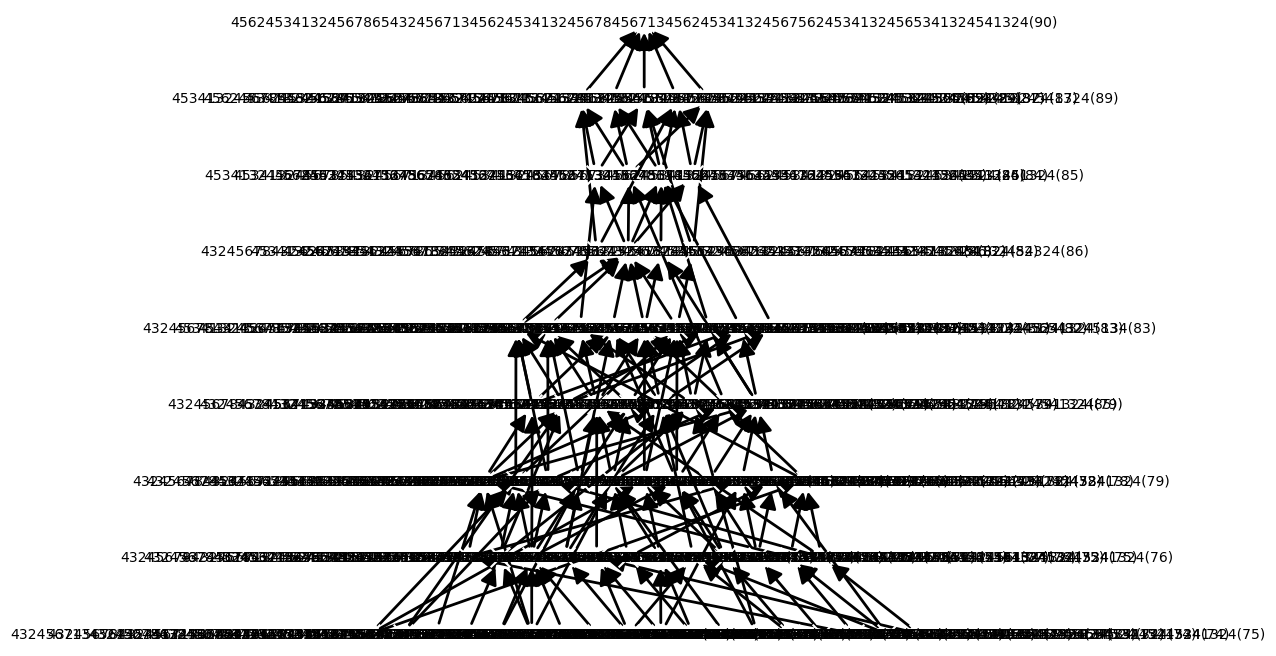

In [16]:
def human(w):
    return convert_to_123(w)+"(%s)"%w.length()
    #return "%s"%w.length()


def print_poset(P, **kwargs):
    size = kwargs.get('size', 10)
    red = kwargs.get('red', False)
    i = kwargs.get('i', None)
    j = kwargs.get('j', None)
    
    if red==True:
        color = {"red" : [(human(x[0]),human(x[1])) for x in P.cover_relations() if not is_socle_killing_pair(x[0],x[1],i,j)]}
    else:
        color = {}
    show(P.relabel(lambda x: human(x)).plot(figsize = size, vertex_shape="x", vertex_color="white",  cover_colors = color))
    

Pos = W_subposet(Q[2])

print_poset(Pos)
    

In [ ]:
# A code for finding socles in cases when length of chains match the number of monomials


def r(i,j):
    return len((p[i,j]).exponents())-1


socles = {}


for i in range(1,n+1):
    for j in range(i,n+1):
        
        if i==4 and j==4:

            size = 5

            print("i, j = %d, %d" %(i,j))

            P = load_poset("JI_socle_killing",i,j)
            #        print_poset(P, size=size, red=True, i=i, j=j)

            print("p_%d%d=%s" %(i,j,p[(i,j)]))
            print("r=%d" %r(i,j))
            al = P.level_sets()
            print( "al={%s}" %al  )
            bl = (P.dual()).level_sets()
            print( "bl={%s}" %bl  )

            print()

            if r(i,j)+1==len(al) and r(i,j)+1==len(bl):
                print("r+1=|al|=|bl|")

                print()

                for k in range(r(i,j)+1):
                    if set(al[k]) == set(bl[r(i,j)-k]):
                        print("al[%d] == bl[r-%d]: %s" %(k,k  , True  ) )   

                        c = p[(i,j)].dict()[sorted(p[(i,j)].dict().keys())[k]]
                        print("c=%d"%c)
                        
                        ww = join_rBG( al[k], Q[ r(i,j)-k  ] )
                        #ww = join_B(al[k],i,j)
                            
                        al[k].sort(key = br_le)

                        for w in al[k]:
                            m=1
                            w_ = copy(w)



                            while w_ != ww:
                                for vv in al[k]:
                                    w_vv = join_rBG( [w_,vv], Q[ r(i,j)-k  ]   )
                                    #w_vv = join_B([w_,vv],i,j)

                                    #if w_vv == 0: # join does not exist
                                    #    problem = True
                                    #    break

                                    if w_ != w_vv and w_vv !=0:
                                        w_ = w_vv
                                        m += 1

                            if m == c:
                                print('%s has simple socle' %human(w))
                                socles[w] = (H[i,j], sorted(list(p[(i,j)].dict()))[k])  # check this !!
                            else:
                                print('not sure about %s' %human(w))
                                print("m=%d"%m)


                    else:
                        print("al[%d] == bl[r-%d]: %s" %(k,k  , False  ) )

            else:
                print("r=%d, |al|=%d, |bl|=%d do not match?" %(r(i,j), len(al), len(bl) ))


            print("\n\n**************************************")

In [ ]:
def join_B(S,i,j):
    '''A new version that loads the previously saved posets.
    Here S is assumed to be a list of elements from JI[(i,j)].'''
    U = set(x for x in BG[(i,j)] if (S[0]).bruhat_le(x) )
    for a in S[1:]:
        U = U.intersection(set(x for x in BG[(i,j)] if a.bruhat_le(x) ))
        
    result = (  load_poset("BG",i,j).subposet(list(U))     ).minimal_elements()
    if len(result)==1:
        return result[0]
    else:
#        raise ValueError
        return 0 # Join does not exist




# A code for finding socles in cases when length of chains match the number of monomials

socles = {}


for i in range(1,n+1):
    for j in range(i,n+1):
        size = 5
        
        print("i, j = %d, %d" %(i,j))

        P = load_poset("JI_socle_killing",i,j)
        #        print_poset(P, size=size, red=True, i=i, j=j)

        print("p_%d%d=%s" %(i,j,p[(i,j)]))
        print("r=%d" %r(i,j))
        al = P.level_sets()
        print( "al={%s}" %al  )
        bl = (P.dual()).level_sets()
        print( "bl={%s}" %bl  )

        print()

        if r(i,j)+1==len(al) and r(i,j)+1==len(bl):
            print("r+1=|al|=|bl|")

            print()

            for k in range(r(i,j)+1):
                if set(al[k]) == set(bl[r(i,j)-k]):
                    print("al[%d] == bl[r-%d]: %s" %(k,k  , True  ) )   

                    c = p[(i,j)].dict()[sorted(p[(i,j)].dict().keys())[k]]
                    print("c=%d"%c)

                    ww = join_B(al[k],i,j)
                    al[k].sort(key = br_le)

                    for w in al[k]:
                        m=1
                        w_ = copy(w)



                        while w_ != ww:
                            for vv in al[k]:
                                w_vv = join_B([w_,vv],i,j)

                                #if w_vv == 0: # join does not exist
                                #    problem = True
                                #    break

                                if w_ != w_vv and w_vv !=0:
                                    w_ = w_vv
                                    m += 1

                        if m == c:
                            print('%s has simple socle' %human(w))
                            socles[w] = (H[i,j], sorted(list(p[(i,j)].dict()))[k])  # check this !!
                        else:
                            print('not sure about %s' %human(w))
                            print("m=%d"%m)


                else:
                    print("al[%d] == bl[r-%d]: %s" %(k,k  , False  ) )

        else:
            print("r=%d, |al|=%d, |bl|=%d do not match?" %(r(i,j), len(al), len(bl) ))


        print("\n\n**************************************")

i, j = 1, 1
p_11=v^46 + v^52 + v^56 + v^62
r=3
al={[[s1], [s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1], [s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1]]}
bl={[[s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4*s3*s1], [s1*s3*s4*s5*s2*s4*s3*s1, s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s2*s4*s3*s1], [s1]]}

r=3, |al|=3, |bl|=3 do not match?


**************************************
i, j = 1, 2
p_12=v^49 + v^53 + v^55 + v^59
r=3
al={[[s1*s3*s4*s2], [s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2], [s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2]]}
bl={[[s1*s3*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4*s2], [s1*s3*s4*s5*s6*s7*s2*s4*s5*s6*s3*s4*s5*s1*s3*s4*s2, s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s2], [s1*s3*s4*s2]]}

r=3, |al|=3, |bl|=3 do not match?


*********************

24(2) has simple socle
al[1] == bl[r-1]: True
c=1
24534(5) has simple socle
al[2] == bl[r-2]: True
c=2
245634524(9) has simple socle
245341324(9) has simple socle
2456345134(10) has simple socle
al[3] == bl[r-3]: True
c=2
24567345624534(14) has simple socle
245634132454324(15) has simple socle
245673456134524(15) has simple socle
al[4] == bl[r-4]: True
c=2
245673456245341324(18) has simple socle
24534132456543245134(20) has simple socle
2456734132456432454324(22) has simple socle
al[5] == bl[r-5]: True
c=2
2453413245675432456134524(25) has simple socle
2456734132456453413245341324(28) has simple socle
2453413245675432456543245134(28) has simple socle
al[6] == bl[r-6]: True
c=1
24534132456756453413245634132454324(35) has simple socle
al[7] == bl[r-7]: True
c=1
24567345624534132456724534132456543245134(41) has simple socle


**************************************
i, j = 2, 5
p_25=v^48 + v^50 + 2*v^52 + v^54 + 2*v^56 + v^58 + v^60
r=6
al={[[s2*s4*s5], [s2*s4*s5*s6*s3*s4*s5, s2*s4*s5*s3*s4

34(2) has simple socle
al[1] == bl[r-1]: True
c=2
34524(5) has simple socle
341324(6) has simple socle
345134(6) has simple socle
al[2] == bl[r-2]: True
c=2
345624534(9) has simple socle
3456134524(10) has simple socle
34132454324(11) has simple socle
al[3] == bl[r-3]: True
c=3
3456245341324(13) has simple socle
34567245634524(14) has simple socle
345672456345134(15) has simple socle
345671345624534(15) has simple socle
3413245643245134(16) has simple socle
34132456432454324(17) has simple socle
al[4] == bl[r-4]: True
c=3
3456713456245341324(19) has simple socle
34567245634132454324(20) has simple socle
341324567432456134524(21) has simple socle
34132456743245643245134(23) has simple socle
34132456453413245341324(23) has simple socle
341324567432456432454324(24) has simple socle
al[5] == bl[r-5]: True
c=2
3456724534132456543245134(25) has simple socle
341324567432456453413245341324(30) has simple socle
341324567453413245634132454324(30) has simple socle
al[6] == bl[r-6]: True
c=2
34562

bl={[[s4*s3*s2*s4*s5*s6*s7*s1*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4], [s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s7*s3*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4], [s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s6*s5*s4*s3*s2*s4*s5*s6*s1*s3*s4*s5*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s3*s4*s1*s3*s2*s4*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s3*s4*s1*s3*s2*s4, s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s5*s6*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s3*s4*s1*s3*s2*s4*s5*s4*s3*s2*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s5*s4*s3*s2*s4*s5*s1*s3*s4, s4*s5*s6*s2*s4*s5*s3*s4*s1*s3*s2*s4*s5*s6*s7*s4*s

In [ ]:
def is_socle_killing_chain(chain, wrong):
    '''Assuming chain is a list b1 < b2 < ... < bm, all from the same JI(i,j).
    wrong = complement_BG(i,j), but I want to calculate it in the outer function,
    so that it does not recalculate many times.'''
    
    for t in range(len(chain)-1):
        if is_socle_killing_pair(chain[t],chain[t+1], wrong) == False:
            return False
    return True
    
def order_chains(x,y):
    return (set(x)).issubset(set(y))

def max_socle_killing_chains(i,j):
    wrong = complement_BG(i,j)
    all_socle_killing_chains =  [tuple(chain) for chain in W_subposet(JI[(i,j)]).chains() if len(chain)>=2 and is_socle_killing_chain(chain, wrong)]

    return Poset((all_socle_killing_chains,order_chains)).maximal_elements()   



    
    
    